### Percobaan 3

Resize, Graysacle, Ekualisasi, Median dan Gaussian Blur

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di atas digunakan dalam projek klasifikasi citra retina dan diawali dengan mengimpor berbagai pustaka yang dibutuhkan untuk membaca data, melakukan ekstraksi fitur, membangun model klasifikasi, dan mengevaluasi performanya. Pustaka <code>os</code> digunakan untuk navigasi direktori dan mengakses file gambar, sementara <code>cv2</code> (OpenCV) berfungsi untuk membaca serta memproses citra retina. Untuk keperluan visualisasi data dan hasil klasifikasi, digunakan <code>matplotlib.pyplot</code> dan <code>seaborn</code>. Manipulasi data numerik dan tabular dilakukan menggunakan <code>numpy</code> dan <code>pandas</code>. Pembagian data menjadi data latih dan uji dilakukan dengan <code>train_test_split</code>, sedangkan <code>cross_val_predict</code> digunakan untuk validasi silang dalam prediksi. Evaluasi model dilakukan dengan berbagai metrik seperti akurasi, presisi, recall, f1-score, dan confusion matrix yang disediakan oleh <code>sklearn.metrics</code>. Untuk ekstraksi fitur tekstur dari gambar, digunakan metode GLCM melalui fungsi <code>graycomatrix</code> dan <code>graycoprops</code> dari pustaka <code>skimage.feature</code>, serta entropi dihitung menggunakan fungsi <code>entropy</code> dari <code>scipy.stats</code>. Tiga model klasifikasi yang digunakan dalam kode ini adalah Random Forest, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN), yang semuanya diimpor dari <code>sklearn</code>.

</div>


## Data Loading

In [2]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            # Ambil channel hijau dari gambar
            green = img[:, :, 1]
            green = cv.resize(green, (150, 150)) # Resize gambar yag diambil
            green = green.astype(np.uint8)

            data.append(green)
            labels.append(sub_folder)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di atas digunakan untuk memuat dan memproses citra retina dari dataset yang tersusun dalam struktur direktori berdasarkan label kelas. Terdapat empat kategori label yang digunakan, yaitu <b>katarak</b>, <b>diabetic retinopathy</b>, <b>glaukoma</b>, dan <b>normal</b>. Setiap kategori diwakili oleh sebuah subfolder di dalam direktori <code>dataset\\</code>, dan masing-masing berisi gambar retina yang termasuk dalam kategori tersebut.

Program menelusuri setiap subfolder, lalu membaca gambar-gambar di dalamnya menggunakan OpenCV. Jika gambar berhasil dimuat, program mengambil channel hijau (indeks ke-1) dari gambar RGB, karena channel ini umumnya memberikan kontras terbaik untuk mendeteksi struktur penting retina seperti pembuluh darah. Gambar tersebut kemudian diubah ukurannya menjadi <b>150x150 piksel</b> dan dikonversi ke tipe data <code>uint8</code> untuk memastikan kompatibilitas saat proses pengolahan.

Setelah itu, gambar yang telah diproses disimpan dalam array <code>data</code>, labelnya disimpan dalam <code>labels</code>, dan nama file disimpan ke dalam <code>file_name</code>. Seluruh data kemudian dikonversi menjadi array NumPy agar efisien digunakan pada proses ekstraksi fitur dan pelatihan model klasifikasi citra retina.
</div>


## Data Preparation

### Define Preprocessing

In [3]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def median_filter(img, kernel_size=3):
    pad_size = kernel_size // 2
    padded = np.pad(img, pad_size, mode='edge')
    filtered = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Ambil jendela lokal
            window = padded[i:i+kernel_size, j:j+kernel_size].flatten()
            # Hitung median
            median_val = np.median(window)
            filtered[i, j] = median_val

    return filtered.astype(np.uint8)

def gaussian_blur(img, kernel_size=5, sigma=1):
    # Membuat kernel Gaussian 2D
    kx = cv.getGaussianKernel(kernel_size, sigma)
    ky = cv.getGaussianKernel(kernel_size, sigma)
    kernel = np.outer(kx, ky)  # Membuat kernel 2D

    # Menambahkan padding pada gambar untuk menghindari batasan gambar
    padded = np.pad(img, kernel_size//2, mode='edge')
    blurred = np.zeros_like(img)
    
    # Melakukan konvolusi (filtering) antara gambar dan kernel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            blurred[i, j] = np.sum(region * kernel)  # Perkalian elemen per elemen dan penjumlahan
    
    return np.clip(blurred, 0, 255).astype(np.uint8)


<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di atas terdiri dari tiga fungsi pengolahan citra grayscale yang berfungsi untuk meningkatkan kualitas gambar melalui teknik peningkatan kontras dan pengurangan noise.

Fungsi pertama, <code>histogram\_equalization</code>, melakukan ekualisasi histogram pada citra grayscale. Proses dimulai dengan menghitung histogram distribusi intensitas piksel dan bin yang sesuai. Kemudian, fungsi menghitung cumulative distribution function (CDF) dari histogram tersebut dan menormalisasi CDF agar nilai maksimum menjadi 255, sesuai dengan rentang intensitas piksel. Selanjutnya, fungsi melakukan interpolasi nilai piksel asli menggunakan CDF yang telah dinormalisasi untuk menghasilkan distribusi intensitas yang lebih merata. Proses ini meningkatkan kontras gambar sehingga detail pada area gelap dan terang menjadi lebih jelas. Hasil akhir dikembalikan sebagai array dua dimensi dengan tipe data <code>uint8</code>.

Fungsi kedua, <code>median\_filter</code>, adalah filter median yang digunakan untuk mereduksi noise terutama noise impulsif (salt and pepper noise). Fungsi ini menerima citra grayscale dan ukuran kernel (default 3x3). Gambar dipadding menggunakan mode 'edge' agar proses filter bisa diterapkan sampai pada tepi gambar. Untuk setiap piksel, fungsi mengambil jendela lokal sekeliling sebesar kernel, kemudian menghitung median nilai piksel dalam jendela tersebut, dan menyimpan nilai median sebagai nilai piksel baru. Filter median efektif menjaga tepi (edges) gambar tetap tajam sambil menghilangkan noise.

Fungsi ketiga, <code>gaussian\_blur</code>, menerapkan filter Gaussian untuk menghaluskan gambar dan mengurangi noise dengan cara melakukan konvolusi citra dengan kernel Gaussian 2D. Kernel Gaussian dibuat menggunakan fungsi <code>cv.getGaussianKernel</code> dari OpenCV untuk sumbu x dan y, lalu dikalikan untuk membentuk kernel 2D. Gambar dipadding dengan mode 'edge' agar pengolahan konvolusi dapat dilakukan hingga batas gambar. Setiap piksel kemudian diproses dengan menjumlahkan hasil perkalian elemen kernel dengan wilayah lokal citra di sekitarnya. Hasil blur dikontrol agar tetap dalam rentang 0 hingga 255 dan dikonversi ke <code>uint8</code>. Filter ini efektif mengurangi noise sekaligus mempertahankan transisi halus pada gambar.

</div>


---


## Preprocessing

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di atas berfungsi untuk melakukan pra-pemrosesan citra retina menggunakan kombinasi tiga metode dan menampilkan hasilnya secara visual berdasarkan label kelasnya. Fungsi <code>percobaan3</code> menerima sebuah gambar grayscale dari channel hijau, kemudian menerapkan tiga tahapan pengolahan citra secara berurutan: pertama melakukan <em>histogram equalization</em> untuk meningkatkan kontras citra, kedua menerapkan <em>median filter</em> untuk menghilangkan noise impulsif dan mempertahankan tepi gambar, dan ketiga menerapkan <em>Gaussian blur</em> untuk menghaluskan citra dan mereduksi noise halus. Fungsi ini mengembalikan citra yang sudah diproses secara lengkap.

Selanjutnya, seluruh gambar pada dataset <code>data</code> diproses menggunakan fungsi <code>percobaan3</code> dan hasilnya disimpan dalam list baru bernama <code>dataPreprocessed</code>. Kemudian, kode mengambil semua label unik dari dataset, yang diasumsikan mewakili kelas-kelas penyakit atau kondisi normal.

Untuk visualisasi, dibuat sebuah grid berukuran 7x12, yang dapat menampung hingga 84 gambar untuk setiap kelas. Pada setiap kelas, kode mencari indeks semua gambar yang memiliki label tersebut, lalu menampilkan 84 citra hasil pra-pemrosesan dalam subplot-grid tersebut menggunakan peta warna grayscale. Sumbu (axis) dari setiap subplot disembunyikan agar tampilan lebih bersih dan fokus pada citra. Judul utama pada setiap grid menyatakan metode pra-pemrosesan yang digunakan serta label kelas gambar yang ditampilkan.
</div>


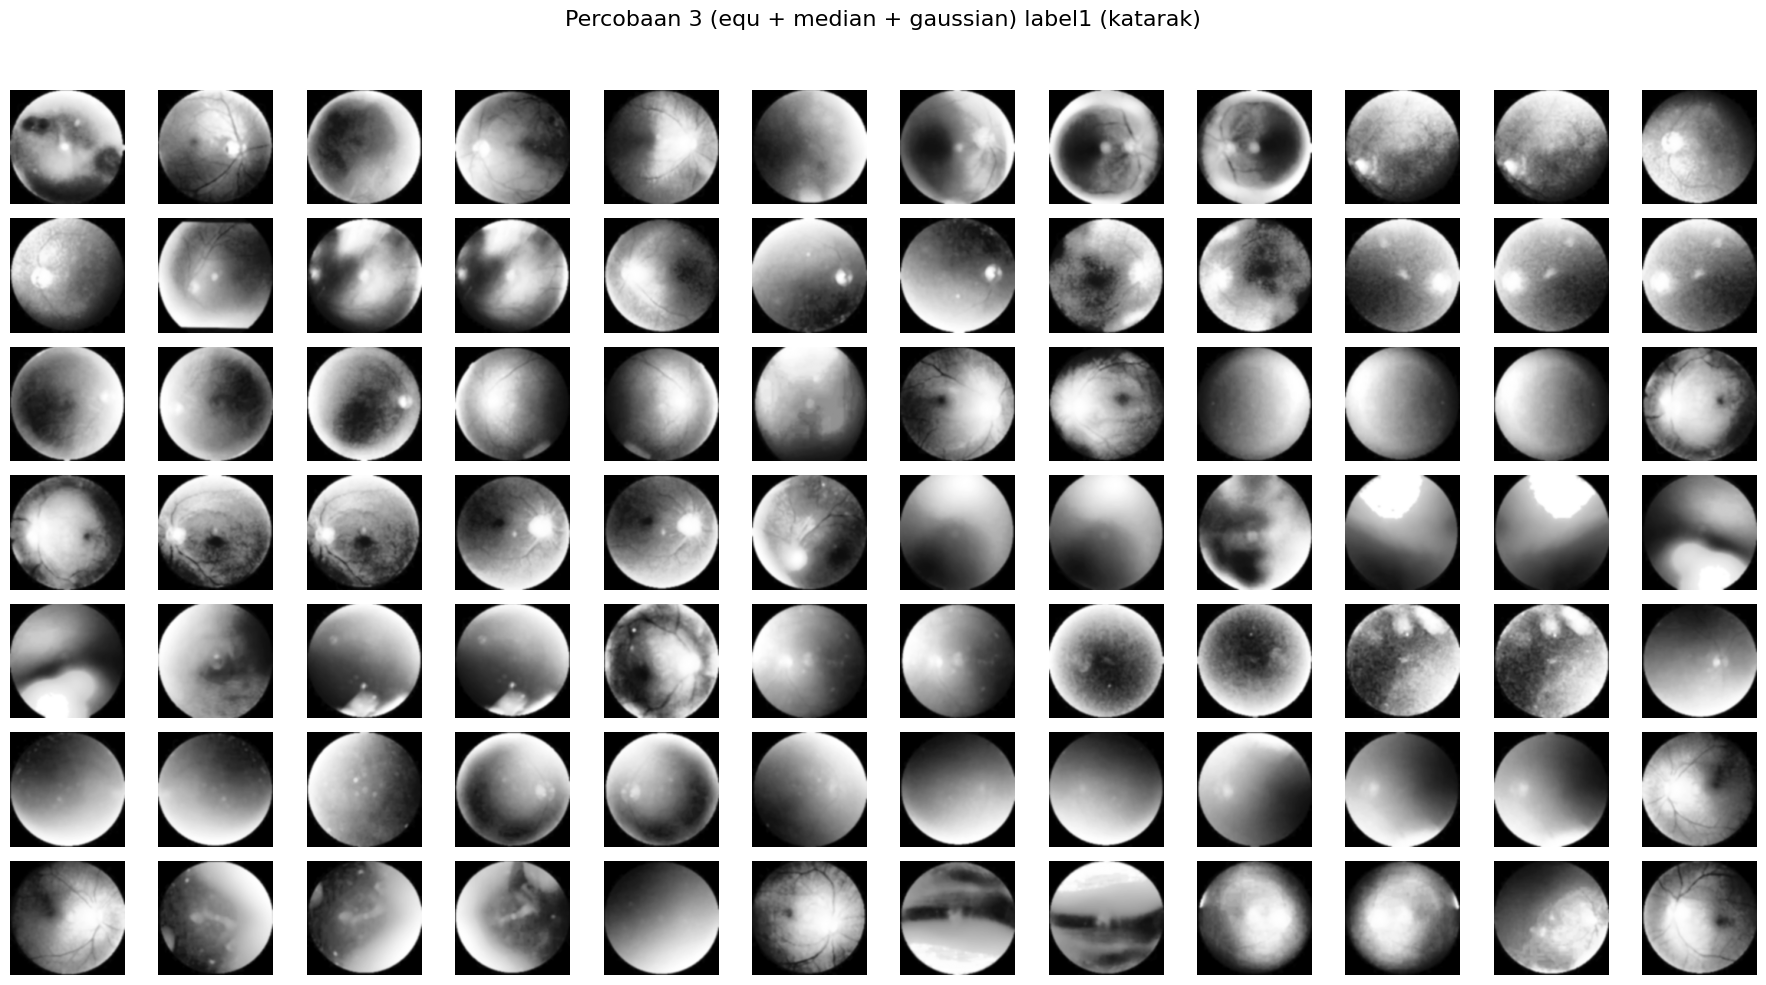

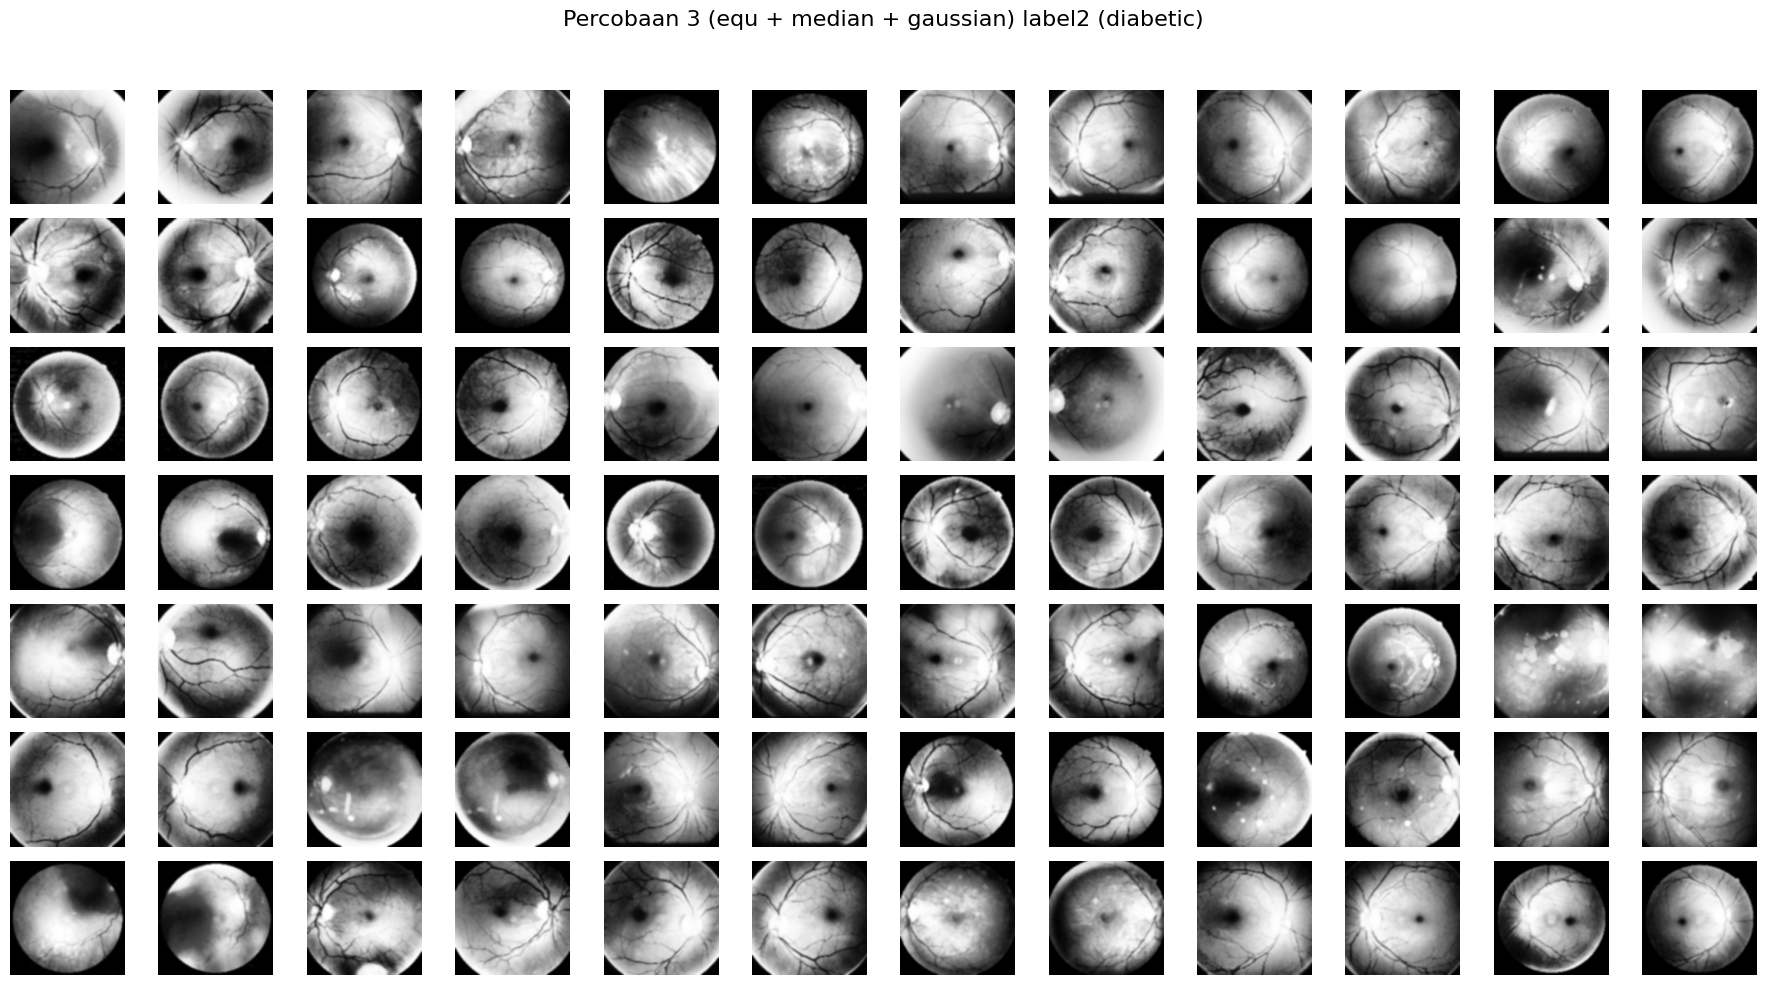

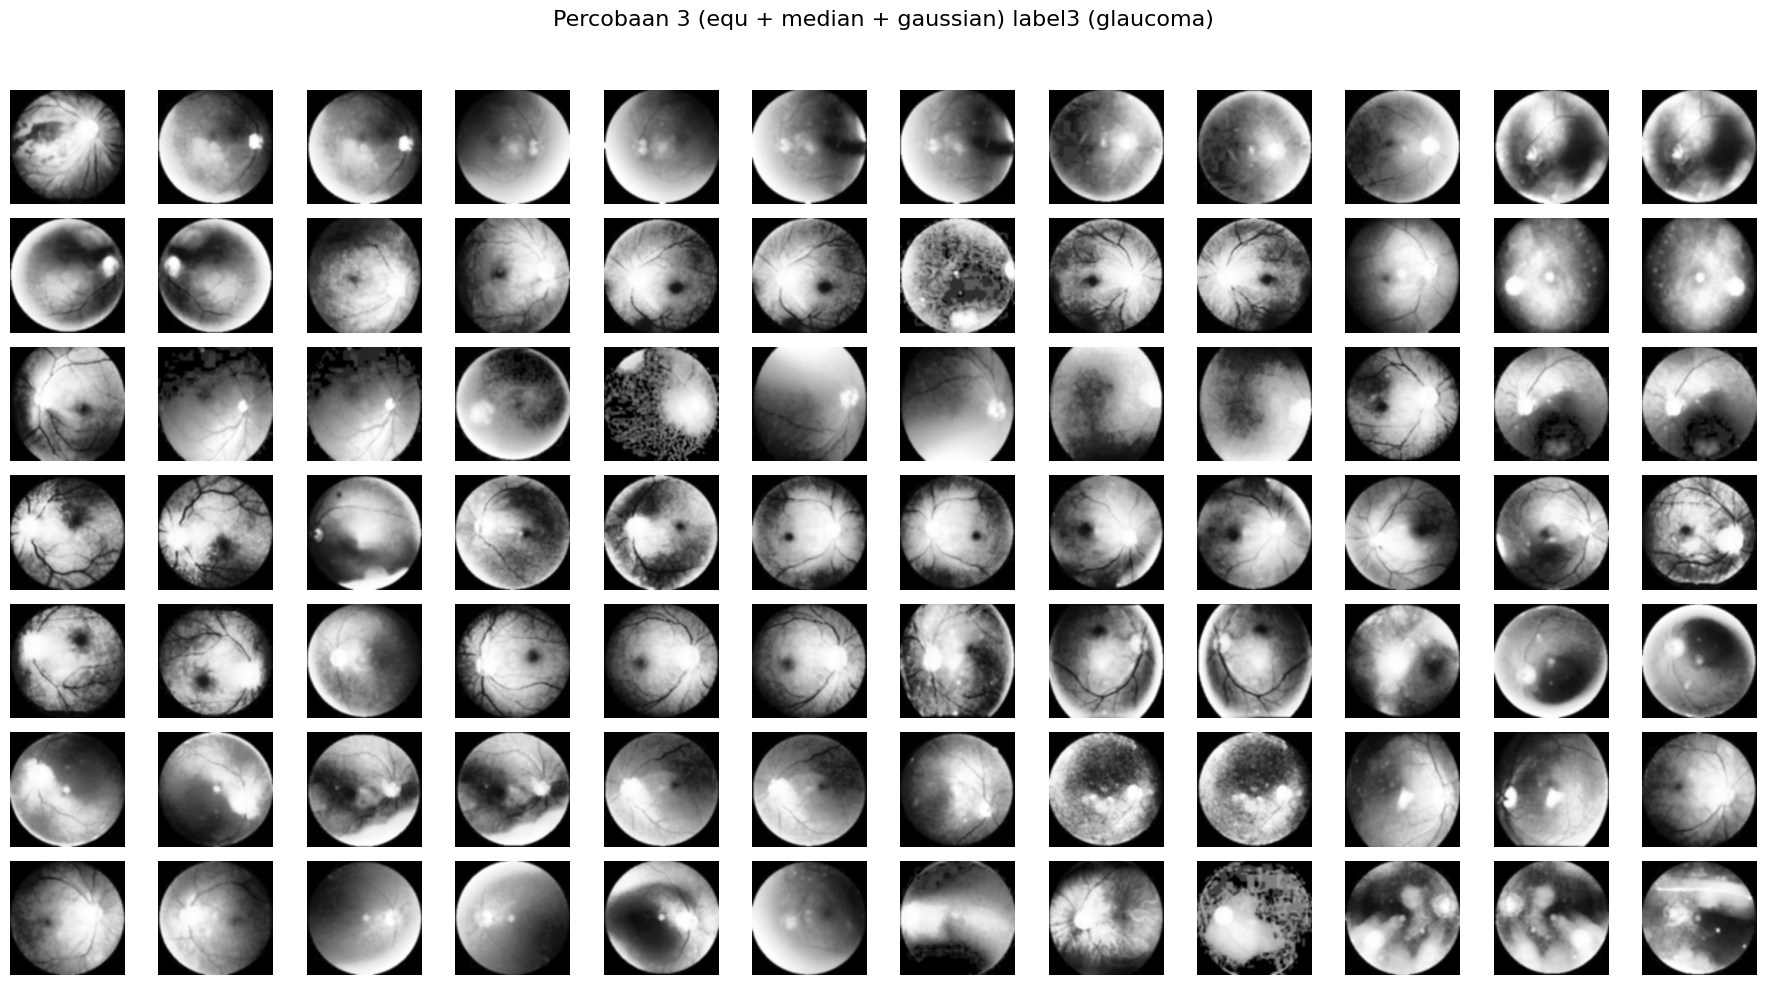

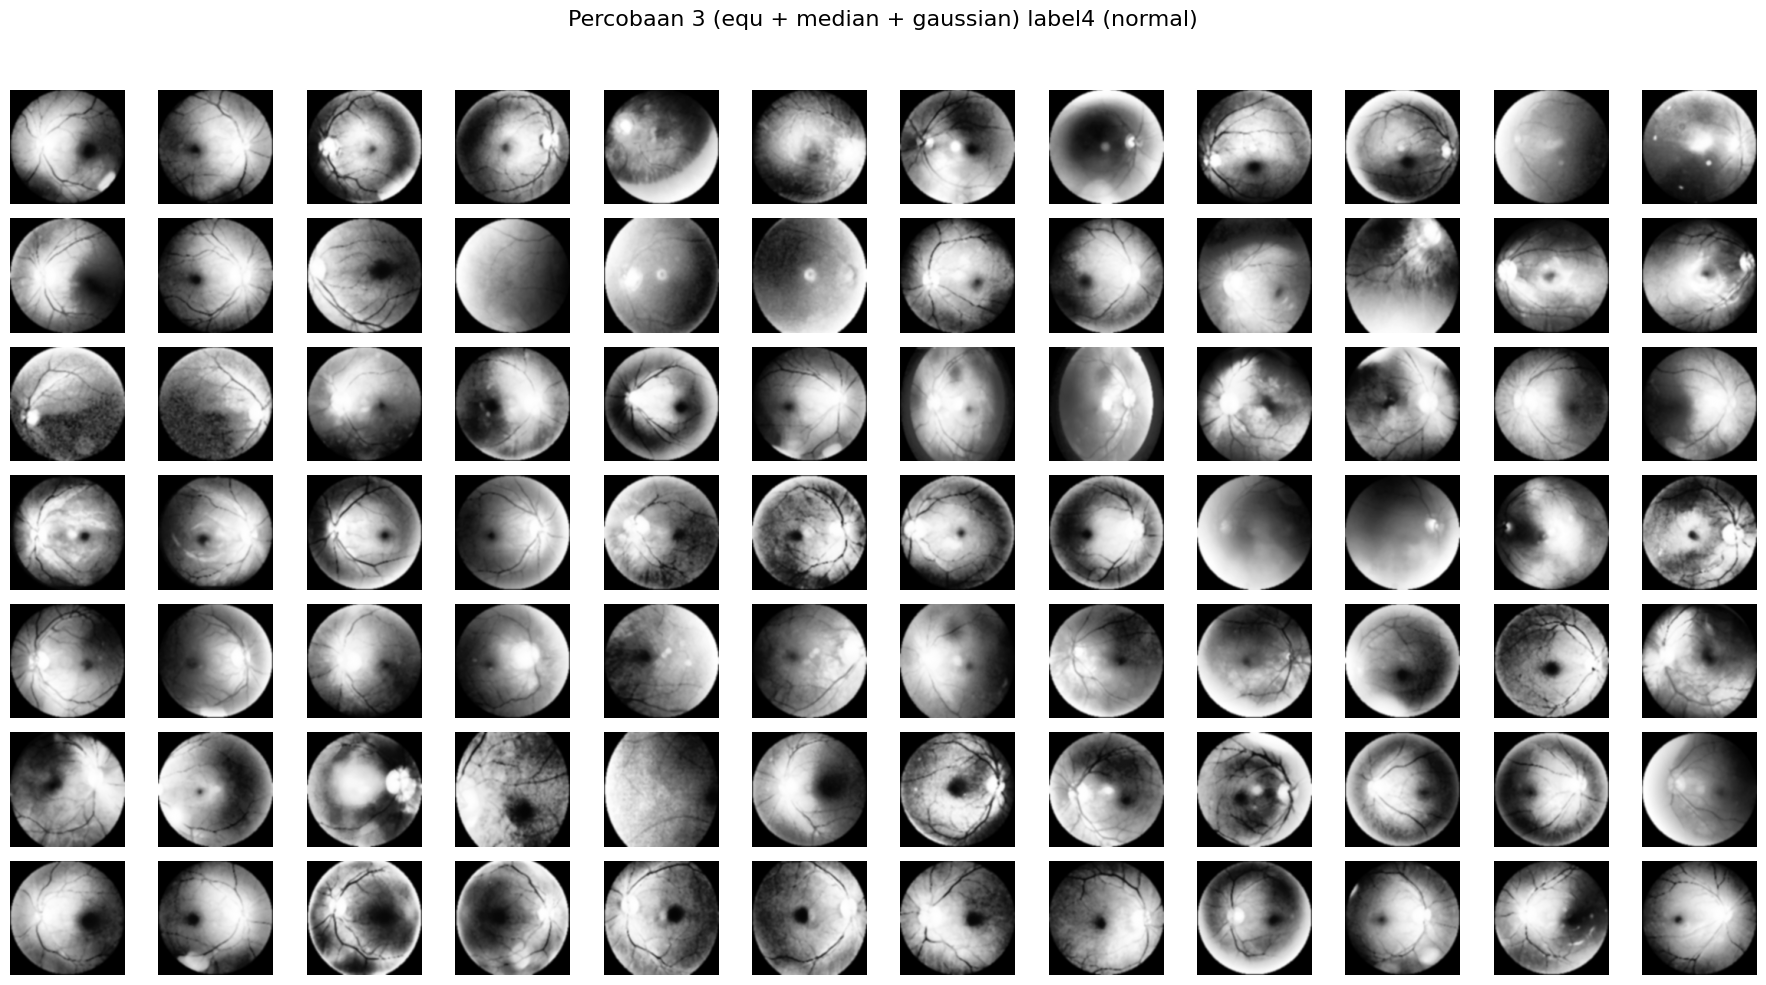

In [4]:
def percobaan3(green):
    img_eq = histogram_equalization(green)
    img_med = median_filter(img_eq)
    img_gau = gaussian_blur(img_med)
    return img_gau

dataPreprocessed = [percobaan3(img) for img in data]  

unique_labels = sorted(set(labels))


for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan 3 (equ + median + gaussian) {label}', fontsize=16)
    
    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()

## Ekstraksi Fitur

In [5]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi <code>glcm</code> di atas digunakan untuk menghitung matriks co-occurrence tingkat abu-abu (Gray-Level Co-occurrence Matrix atau GLCM) dari sebuah citra grayscale berdasarkan sudut tertentu. Fungsi menerima dua parameter: <code>image</code>, yaitu citra input dalam format array dua dimensi, dan <code>derajat</code>, yang merupakan sudut orientasi yang ingin digunakan dalam perhitungan GLCM (hanya menerima nilai 0, 45, 90, atau 135 derajat). Berdasarkan nilai <code>derajat</code>, fungsi mengonversinya menjadi radian sesuai standar, misalnya 0 derajat menjadi 0 radian, 45 derajat menjadi π/4, 90 derajat menjadi π/2, dan 135 derajat menjadi 3π/4. Jika sudut yang diberikan tidak valid, fungsi akan mengeluarkan <code>ValueError</code>.

Setelah menentukan sudut, fungsi memanggil <code>graycomatrix</code> dari pustaka <code>skimage.feature</code> untuk menghasilkan matriks GLCM dengan jarak piksel sebesar 1, sudut sesuai parameter, 256 level intensitas abu-abu (misalnya untuk gambar 8-bit), serta opsi <code>symmetric=True</code> dan <code>normed=True</code> yang membuat matriks simetris dan ternormalisasi sehingga nilai-nilai di dalamnya merepresentasikan probabilitas ko-occurrence. Matriks GLCM yang dihasilkan merepresentasikan frekuensi relatif pasangan nilai intensitas piksel yang muncul berdekatan dengan orientasi tertentu dalam citra. Matriks ini sangat berguna dalam ekstraksi fitur tekstur untuk analisis citra.

Fungsi kemudian mengembalikan matriks GLCM tersebut dalam bentuk array numpy.

</div>

In [6]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di atas mendefinisikan beberapa fungsi untuk mengekstraksi fitur tekstur dari matriks Gray-Level Co-occurrence Matrix (GLCM) menggunakan pustaka <code>skimage.feature</code> dan fungsi entropi dari <code>scipy.stats</code>. Setiap fungsi menerima sebuah matriks GLCM sebagai input dan mengembalikan nilai tunggal yang merepresentasikan fitur tekstur tertentu.

Fungsi-fungsi tersebut meliputi:  
- <code>correlation</code>: Menghitung korelasi, yang menunjukkan derajat linearitas hubungan antara piksel tetangga dalam citra.  
- <code>dissimilarity</code>: Mengukur perbedaan intensitas antara piksel yang berpasangan, memberikan gambaran seberapa kontras tekstur.  
- <code>homogenity</code>: Mengukur keseragaman atau kehalusan tekstur, dengan nilai tinggi menunjukkan tekstur yang lebih seragam.  
- <code>contrast</code>: Mengukur variasi intensitas dalam citra, semakin tinggi nilai kontras, semakin tajam teksturnya.  
- <code>ASM</code> (Angular Second Moment): Menggambarkan tingkat keteraturan atau homogenitas matriks, juga dikenal sebagai energi kuadrat.  
- <code>energy</code>: Merupakan akar kuadrat dari ASM, merepresentasikan kekuatan tekstur.  
- <code>entropyGlcm</code>: Menghitung entropi dari matriks GLCM, yaitu ukuran kompleksitas atau ketidakpastian dalam tekstur citra.

Untuk fitur-fitur selain entropi, fungsi menggunakan <code>graycoprops</code> untuk mengakses properti yang bersangkutan dari GLCM, dan mengambil nilai pertama (pada indeks [0,0]) karena GLCM yang digunakan memiliki satu sudut dan jarak. Sedangkan fungsi <code>entropyGlcm</code> menghitung entropi dengan meratakan matriks menjadi vektor 1 dimensi lalu menghitung nilai entropinya, memberikan ukuran kerandoman tekstur.

Kode di atas sangat berguna dalam ekstraksi fitur tekstur untuk analisis dan klasifikasi citra.

</div>

---

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di bawah mendefinisikan sebuah fungsi bernama <code>ekstrak_fitur_glcm</code> yang bertujuan mengekstraksi fitur tekstur dari sekumpulan citra menggunakan matriks Gray-Level Co-occurrence Matrix (GLCM). Fungsi ini menerima dua argumen, yaitu <code>data</code> yang berisi list atau array citra dan <code>nama_prepro</code> berupa string untuk menandai tahap preprocessing yang digunakan pada citra tersebut.  

Di dalam fungsi, setiap citra pada <code>data</code> terlebih dahulu dikonversi ke tipe <code>uint8</code> agar sesuai dengan format yang dibutuhkan oleh fungsi GLCM. Kemudian fungsi <code>glcm</code> dipanggil dengan parameter sudut 0 derajat untuk menghasilkan matriks GLCM dari citra tersebut. Selanjutnya, berbagai fitur tekstur seperti <code>contrast</code>, <code>correlation</code>, <code>energy</code>, <code>homogeneity</code>, <code>dissimilarity</code>, <code>ASM</code>, dan <code>entropy</code> dihitung dari matriks GLCM tersebut menggunakan fungsi-fungsi yang telah didefinisikan sebelumnya. Hasil fitur disimpan dalam dictionary dan ditambahkan ke dalam list <code>fitur_list</code>.  

Setelah seluruh citra diproses, list fitur tersebut diubah menjadi sebuah <code>DataFrame</code> pandas dengan kolom-kolom yang merepresentasikan nilai setiap fitur tekstur. Kolom tambahan bernama <code>tahap</code> juga ditambahkan untuk menandai nama preprocessing yang diterapkan pada citra, sehingga memudahkan identifikasi dan analisis.  

Terakhir, fungsi ini mengembalikan DataFrame tersebut, yang dapat langsung ditampilkan atau dianalisis lebih lanjut.

</div>


In [7]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df3 = ekstrak_fitur_glcm(dataPreprocessed, 'percobaan3')
display(df3)

contrast  correlation    energy  homogeneity  dissimilarity       ASM  \
0    61.887159     0.993220  0.136013     0.467617       3.265682  0.018500   
1    49.373199     0.994574  0.139939     0.454887       3.069396  0.019583   
2    91.691902     0.989622  0.111125     0.409948       3.868188  0.012349   
3    51.103937     0.994246  0.148175     0.456233       2.734810  0.021956   
4    34.010738     0.996293  0.144985     0.443903       2.698076  0.021021   
..         ...          ...       ...          ...            ...       ...   
331  40.415570     0.995260  0.172088     0.409617       3.419776  0.029614   
332  96.968904     0.988075  0.177603     0.384749       4.528367  0.031543   
333  32.133557     0.996224  0.181025     0.421853       2.993333  0.032770   
334  46.879642     0.994385  0.181427     0.428444       3.513468  0.032916   
335  17.843535     0.997899  0.182755     0.421183       2.619463  0.033399   

      entropy       tahap  
0    7.156475  percobaan3  
1    7.198373  percobaan3  
2    7.310659  percobaan3  
3    7.011071  percobaan3  
4    7.092996  percobaan3  
..        ...         ...  
331  7.190038  percobaan3  
332  7.224464  percobaan3  
333  7.020664  percobaan3  
334  7.104662  percobaan3  
335  6.948897  percobaan3  

[336 rows x 8 columns]

In [8]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di atas melakukan ekstraksi fitur tekstur Gray-Level Co-occurrence Matrix (GLCM) dari kumpulan citra hasil preprocessing dengan menggunakan empat sudut derajat berbeda: 0°, 45°, 90°, dan 135°. Pada bagian awal, kode membuat empat list kosong (`Derajat0`, `Derajat45`, `Derajat90`, `Derajat135`) yang akan menyimpan matriks GLCM untuk setiap citra pada tiap sudut tersebut. Kemudian, menggunakan fungsi `glcm()`, matriks GLCM dihitung untuk setiap citra dan setiap sudut, lalu disimpan ke dalam list yang sesuai.

Selanjutnya, kode mendefinisikan list kosong untuk setiap fitur tekstur yang akan diekstraksi pada tiap sudut, seperti kontras, dissimilarity, homogenitas, entropi, ASM, energi, dan korelasi. Kemudian, untuk setiap citra, fitur-fitur tersebut dihitung berdasarkan matriks GLCM yang telah disiapkan, dengan memanggil fungsi-fungsi seperti `contrast()`, `dissimilarity()`, `homogenity()`, `entropyGlcm()`, `ASM()`, `energy()`, dan `correlation()`. Nilai-nilai fitur yang diperoleh untuk masing-masing sudut derajat kemudian ditambahkan ke list yang sesuai.

Dengan cara ini, kode menghasilkan fitur tekstur GLCM secara detail pada keempat sudut arah yang berbeda untuk setiap citra dalam dataset. Proses ini memungkinkan analisis tekstur citra yang lebih kaya dan bervariasi. Pendekatan ini meningkatkan kemampuan model dalam membedakan pola-pola tekstur yang mungkin berbeda arah atau orientasi pada citra retina.

</div>


## Hasil Ekstraksi to CSV

In [9]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di atas bertujuan untuk menggabungkan semua fitur tekstur Gray-Level Co-occurrence Matrix (GLCM) yang telah dihitung sebelumnya dari empat sudut derajat (0°, 45°, 90°, dan 135°) ke dalam sebuah struktur data yang rapi dan mudah dianalisis. Pertama, dibuat sebuah list kosong bernama <code>features</code> yang akan menyimpan kumpulan fitur untuk setiap citra. Selanjutnya, dengan melakukan iterasi pada seluruh citra yang telah diproses, fitur-fitur seperti <em>contrast</em>, <em>dissimilarity</em>, <em>homogeneity</em>, <em>entropy</em>, <em>ASM</em>, <em>energy</em>, dan <em>correlation</em> diambil dari matriks GLCM pada masing-masing sudut derajat. Semua fitur tersebut kemudian dikumpulkan dalam sebuah list <code>fitur</code> untuk setiap citra dan ditambahkan ke list <code>features</code>.

Setelah seluruh fitur dari semua citra dikumpulkan, kode kemudian membuat sebuah DataFrame menggunakan pustaka <code>pandas</code> dengan memberikan nama kolom yang jelas untuk setiap fitur dan sudut derajatnya, seperti <code>contrast_0</code>, <code>contrast_45</code>, hingga <code>correlation_135</code>. DataFrame ini bernama <code>df_fitur</code> dan memudahkan analisis selanjutnya, seperti pelatihan model machine learning atau visualisasi data. Dengan struktur data yang terorganisir, fitur tekstur dari berbagai sudut dapat digunakan secara efektif untuk membedakan kelas citra dalam aplikasi pengenalan pola atau klasifikasi medis.

</div>


---

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di bawah membuat sebuah dictionary bernama <code>dataTable</code> yang berisi data hasil ekstraksi fitur tekstur citra dari matriks GLCM, termasuk nama file (<code>Filename</code>), label kelas citra (<code>Label</code>), dan berbagai fitur tekstur seperti <em>Contrast</em>, <em>Homogeneity</em>, <em>Dissimilarity</em>, <em>Entropy</em>, <em>ASM</em>, <em>Energy</em>, serta <em>Correlation</em> yang dihitung untuk masing-masing sudut derajat 0°, 45°, 90°, dan 135°. Data ini kemudian dikonversi menjadi sebuah <code>DataFrame</code> menggunakan pustaka <code>pandas</code> agar mudah diolah dan dianalisis secara tabular. Selanjutnya, <code>DataFrame</code> tersebut disimpan ke dalam file CSV dengan nama <code>hasil_ekstraksi_percobaan2.csv</code> tanpa menyertakan indeks baris untuk menjaga kebersihan data.

Setelah penyimpanan selesai, file CSV yang baru dibuat dibaca kembali menggunakan <code>pd.read_csv</code> dan hasilnya disimpan dalam variabel <code>hasilEkstrak</code>. Variabel ini berisi seluruh data fitur yang telah diekstraksi dan siap digunakan untuk keperluan analisis lebih lanjut, seperti pelatihan model machine learning atau evaluasi kualitas fitur. 
</div>

In [10]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan3.csv')
hasilEkstrak


Filename             Label  Contrast0  Contrast45  Contrast90  \
0     _0_4015166.jpg  label1 (katarak)  61.887159  112.241115   73.920045   
1    _10_3215668.jpg  label1 (katarak)  49.373199   77.077159   44.422685   
2    _11_7158929.jpg  label1 (katarak)  91.691902  174.220035   86.193870   
3    _12_5233869.jpg  label1 (katarak)  51.103937   90.355434   44.033915   
4    _13_3987009.jpg  label1 (katarak)  34.010738   59.992568   22.541879   
..               ...               ...        ...         ...         ...   
331      8_right.jpg   label4 (normal)  40.415570   81.065763   39.599329   
332     939_left.jpg   label4 (normal)  96.968904  165.011621   77.020582   
333    939_right.jpg   label4 (normal)  32.133557   64.413270   26.481790   
334     951_left.jpg   label4 (normal)  46.879642  112.726138   52.204966   
335    951_right.jpg   label4 (normal)  17.843535   37.893068   19.183937   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     151.655646      0.467617       0.382395       0.388125        0.325364   
1     104.286834      0.454887       0.389683       0.426162        0.364698   
2     172.266880      0.409948       0.353780       0.462793        0.368682   
3      94.062385      0.456233       0.434940       0.494632        0.394082   
4      50.521733      0.443903       0.405224       0.497247        0.406947   
..           ...           ...            ...            ...             ...   
331    72.872078      0.409617       0.342439       0.412950        0.360846   
332   174.092834      0.384749       0.327200       0.386325        0.339999   
333    49.263051      0.421853       0.385185       0.446914        0.377606   
334    78.770641      0.428444       0.353263       0.415209        0.385845   
335    33.657763      0.421183       0.381743       0.421438        0.367378   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.018454  0.017123  0.136013  0.131112  0.135846   0.130855   
1    ...  0.019397  0.018108  0.139939  0.134264  0.139275   0.134565   
2    ...  0.012489  0.011108  0.111125  0.105448  0.111753   0.105393   
3    ...  0.021638  0.020159  0.148175  0.142459  0.147098   0.141983   
4    ...  0.021198  0.019627  0.144985  0.140135  0.145595   0.140095   
..   ...       ...       ...       ...       ...       ...        ...   
331  ...  0.029548  0.027738  0.172088  0.166684  0.171896   0.166546   
332  ...  0.031538  0.029607  0.177603  0.171966  0.177588   0.172066   
333  ...  0.032853  0.030806  0.181025  0.175687  0.181254   0.175517   
334  ...  0.032896  0.030938  0.181427  0.175745  0.181372   0.175893   
335  ...  0.033468  0.031463  0.182755  0.177325  0.182943   0.177377   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.993220       0.987652       0.991904        0.983316  
1        0.994574       0.991486       0.995111        0.988480  
2        0.989622       0.980204       0.990247        0.980426  
3        0.994246       0.989789       0.995043        0.989370  
4        0.996293       0.993442       0.997545        0.994477  
..            ...            ...            ...             ...  
331      0.995260       0.990460       0.995355        0.991424  
332      0.988075       0.979636       0.990524        0.978515  
333      0.996224       0.992402       0.996887        0.994189  
334      0.994385       0.986450       0.993748        0.990532  
335      0.997899       0.995520       0.997741        0.996021  

[336 rows x 30 columns]

## Feature Selection

### Correlation

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di bawah bertujuan melakukan seleksi fitur berdasarkan korelasi antar fitur dalam dataset <code>hasilEkstrak</code>. Pertama, dilakukan perhitungan matriks korelasi antar semua fitur numerik dengan menggunakan metode <code>.corr()</code> pada data tanpa kolom <code>Label</code> dan <code>Filename</code>. 

Kemudian, sebuah threshold korelasi ditentukan sebesar 0.95, yang berarti hanya fitur dengan korelasi absolut di atas 0.95 yang akan dianggap sangat mirip dan perlu disaring untuk menghindari redundansi. Melalui loop bersarang, kode memeriksa setiap pasangan fitur dan menandai fitur dengan indeks lebih tinggi untuk diabaikan jika korelasi antar keduanya melewati threshold. Ini dilakukan dengan mengubah nilai boolean di array <code>columns</code> yang melacak fitur mana yang akan dipertahankan (<code>True</code>) dan mana yang dihapus (<code>False</code>).

Setelah proses tersebut, kolom-kolom yang terpilih disimpan dalam variabel <code>select</code>, lalu data fitur baru <code>x_new</code> diambil dari <code>hasilEkstrak</code> dengan hanya menyertakan kolom yang lolos seleksi. Label kelas disimpan di variabel <code>y</code>.

Terakhir, kode menampilkan heatmap korelasi dari fitur yang terpilih menggunakan <code>seaborn</code>, dengan ukuran grafik besar (17x17 inch), anotasi nilai korelasi ditampilkan dengan format dua angka desimal, dan palet warna biru untuk memperjelas hubungan antar fitur yang dipertahankan setelah proses seleksi. Visualisasi ini membantu memahami struktur korelasi fitur yang tersisa.

</div>


<Axes: >

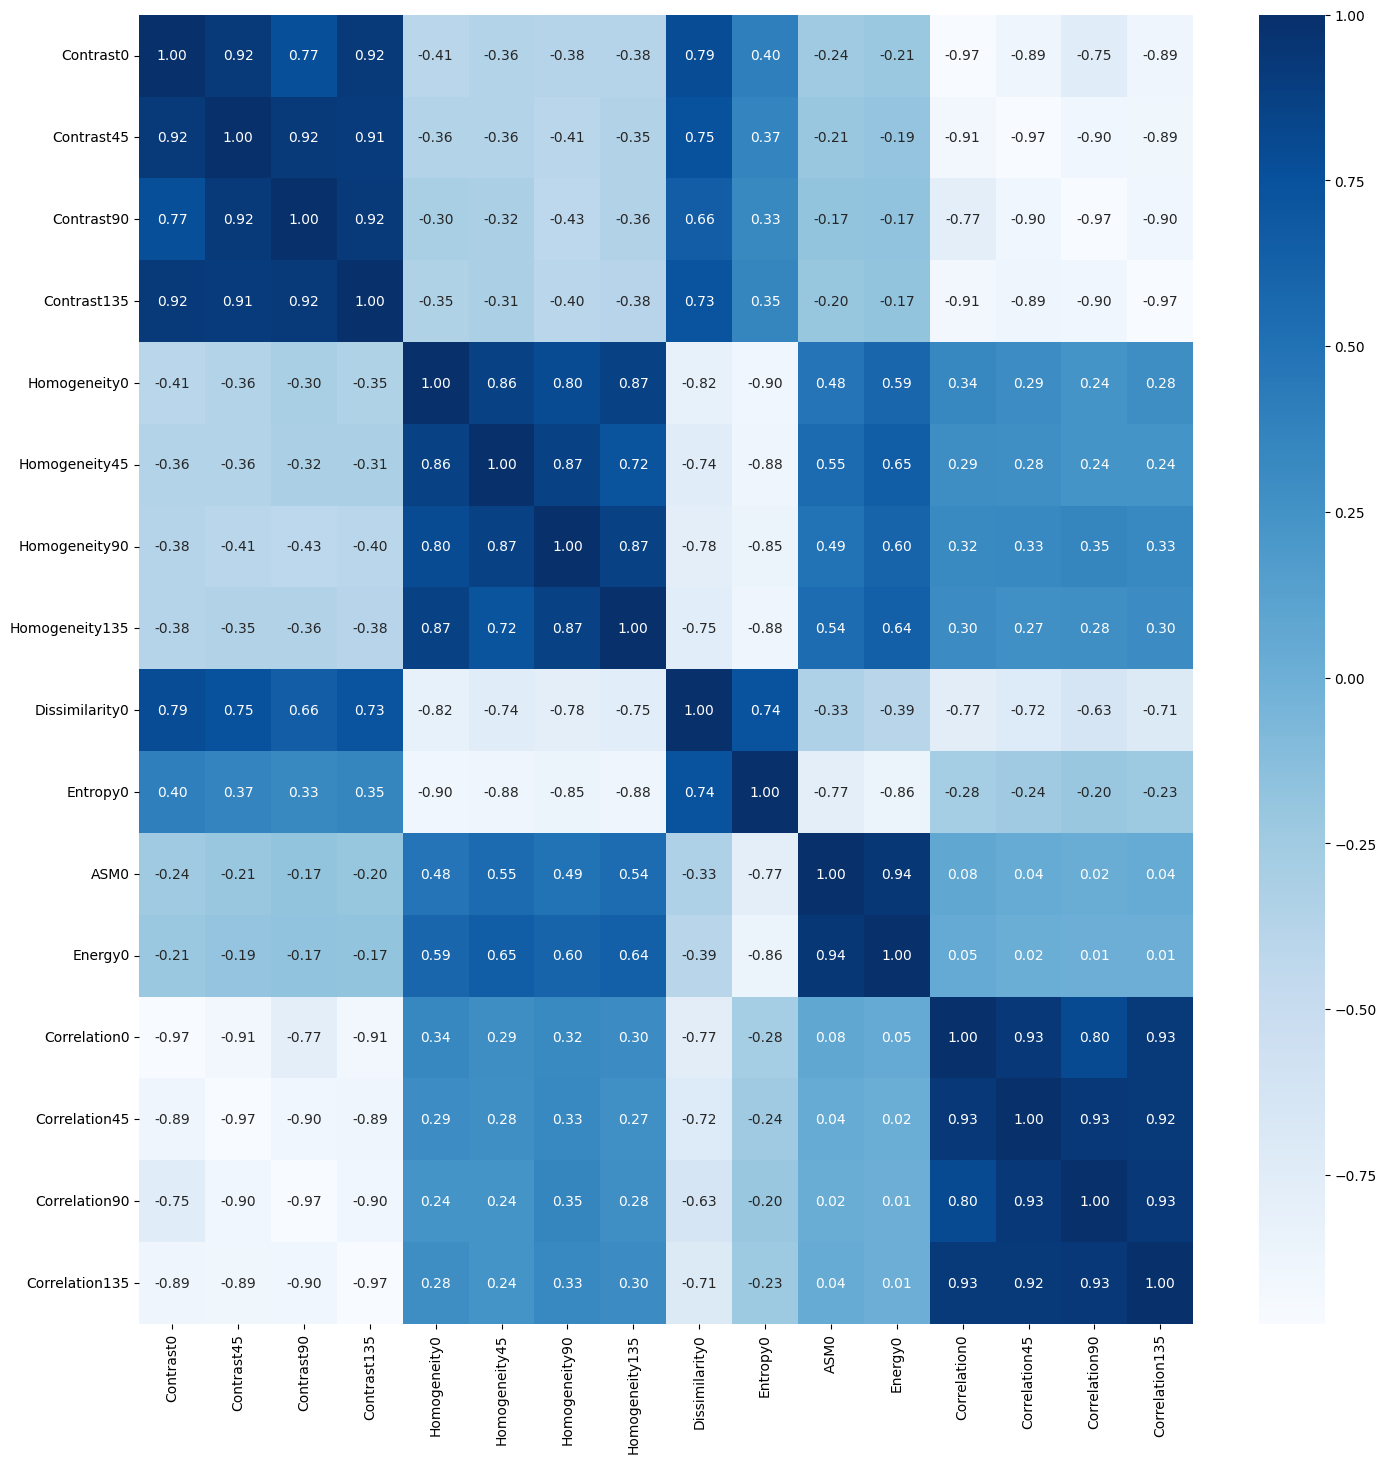

In [11]:
# Selection Correlation
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### LDA

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah melakukan reduksi dimensi fitur menggunakan metode Linear Discriminant Analysis (LDA) untuk tujuan visualisasi dan pemilihan fitur yang paling diskriminatif. Fungsi <code>feature_reduction_lda</code> menerima sebuah <code>dataframe</code> dan jumlah komponen utama yang diinginkan (<code>n_components</code>, default 2). 

Pertama, fungsi memisahkan fitur (dengan menghapus kolom <code>Label</code> dan <code>Filename</code>) dan label kelas dari dataframe. Kemudian, objek LDA dari pustaka <code>sklearn.discriminant_analysis</code> dibuat dengan parameter komponen utama yang diinginkan. LDA kemudian dilatih dan diterapkan pada fitur dan label menggunakan <code>fit_transform</code>, menghasilkan representasi fitur baru dengan dimensi yang lebih rendah.

Hasil transformasi ini dikemas dalam sebuah dataframe baru dengan nama kolom <code>LD1</code> dan <code>LD2</code> untuk dua komponen pertama, serta kolom label kelas asli sebagai referensi. 

Selanjutnya, kode menampilkan visualisasi scatter plot dua dimensi dari hasil LDA menggunakan <code>seaborn</code>. Grafik ini memperlihatkan bagaimana fitur-fitur yang sudah direduksi memisahkan data berdasarkan kelasnya (label), dengan warna berbeda untuk setiap kelas. Plot berukuran 10x6 inch dengan judul, label sumbu, dan legenda yang jelas, sehingga memudahkan interpretasi sebaran dan pemisahan kelas dalam ruang fitur hasil reduksi dimensi.

</div>

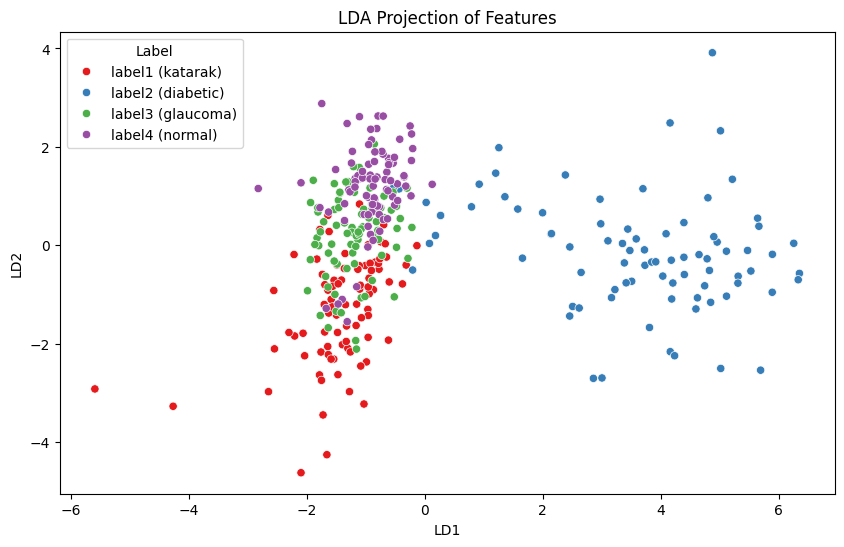

In [12]:
# Selection LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def feature_reduction_lda(dataframe, n_components=2):
    fitur = dataframe.drop(columns=['Label', 'Filename'])
    label = dataframe['Label']
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    x_lda = lda.fit_transform(fitur, label)
    
    columns = [f'LD{i+1}' for i in range(n_components)]
    df_lda = pd.DataFrame(x_lda, columns=columns)
    df_lda['Label'] = label.values
    
    return df_lda

lda_df = feature_reduction_lda(hasilEkstrak, n_components=2)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Label', palette='Set1')
plt.title('LDA Projection of Features')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Label')
plt.show()

### t-SNE

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah melakukan reduksi dimensi data menggunakan metode t-distributed Stochastic Neighbor Embedding (t-SNE) untuk memvisualisasikan data yang kompleks dalam dua dimensi. Pertama, objek t-SNE dari pustaka <code>sklearn.manifold</code> dibuat dengan parameter seperti jumlah dimensi target (<code>n_components=2</code>), perplexity sebesar 30, iterasi maksimal sebanyak 1000, dan <code>random_state=42</code> untuk reproducibility hasil.

Kemudian, t-SNE diterapkan pada data fitur yang telah dipilih (<code>x_new</code>), menghasilkan representasi dua dimensi dari data asli yang memiliki dimensi tinggi. Hasil transformasi disimpan dalam sebuah array dua kolom, yang kemudian dibungkus ke dalam sebuah dataframe <code>df_tsne</code> dengan kolom <code>'Dimensi-1'</code>, <code>'Dimensi-2'</code>, serta kolom <code>'Label'</code> untuk menyimpan label kelas asli.

Selanjutnya, dataframe tersebut divisualisasikan menggunakan plot scatter dari pustaka <code>seaborn</code>, dengan warna berbeda untuk tiap kelas label menggunakan palet warna <code>'Set2'</code>. Titik-titik plot dibuat cukup besar dengan ukuran 100 untuk memudahkan pengamatan. Plot ini diberi judul <i>"Visualisasi t-SNE Data Citra Retina"</i>, disertai legenda yang terletak di posisi terbaik secara otomatis, serta grid untuk memperjelas tata letak visualisasi.

Tujuan utama dari kode ini adalah untuk menampilkan bagaimana data citra retina yang memiliki banyak fitur dapat dikelompokkan dan dipisahkan dalam ruang dua dimensi, sehingga memudahkan analisis visual dan interpretasi pola antar kelas.

</div>


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


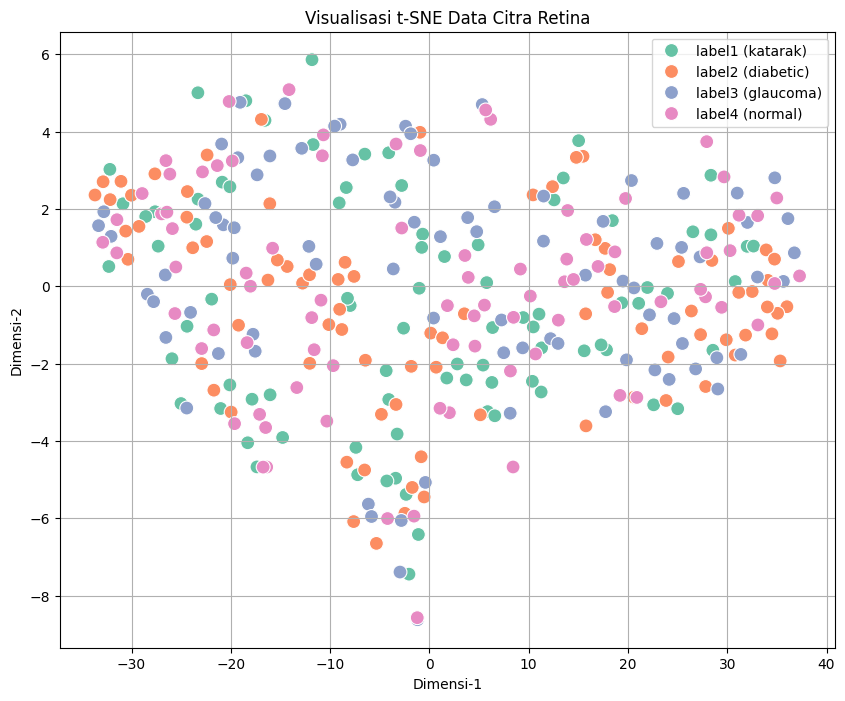

In [13]:
# Selection t-SNE

from sklearn.manifold import TSNE

# Jalankan t-SNE untuk reduksi ke 2 dimensi
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(x_new)

# Buat DataFrame hasil t-SNE
df_tsne = pd.DataFrame()
df_tsne['Dimensi-1'] = X_tsne[:, 0]
df_tsne['Dimensi-2'] = X_tsne[:, 1]
df_tsne['Label'] = y

# Plot dengan seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensi-1', y='Dimensi-2', hue='Label', data=df_tsne, palette='Set2', s=100
)
plt.title('Visualisasi t-SNE Data Citra Retina')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Splitting Data

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah melakukan pembagian dataset menjadi data pelatihan (training) dan data pengujian (testing) menggunakan fungsi <code>train_test_split</code> dari pustaka <code>sklearn.model_selection</code>. Parameter <code>test_size=0.2</code> menunjukkan bahwa 20% dari seluruh data akan dialokasikan sebagai data pengujian, sementara sisanya 80% digunakan sebagai data pelatihan. Parameter <code>random_state=42</code> digunakan untuk memastikan bahwa pembagian data ini konsisten dan dapat direproduksi setiap kali kode dijalankan.

Variabel <code>x_new</code> berisi fitur-fitur yang telah dipilih, sedangkan <code>y</code> adalah label kelas dari masing-masing data. Setelah pembagian, data pelatihan disimpan dalam variabel <code>X_train</code> dan <code>y_train</code>, sedangkan data pengujian disimpan dalam <code>X_test</code> dan <code>y_test</code>.

Output dari kode menampilkan ukuran masing-masing subset data. Terlihat bahwa data pelatihan memiliki 268 sampel dengan 16 fitur, dan data pengujian memiliki 68 sampel dengan 16 fitur. Label data pelatihan dan pengujian masing-masing memiliki panjang 268 dan 68, sesuai dengan jumlah sampel pada fitur.

Pembagian data ini penting dalam machine learning agar model dapat dilatih dengan data pelatihan dan kemudian dievaluasi performanya menggunakan data pengujian yang belum pernah dilihat sebelumnya, guna mengukur kemampuan generalisasi model.

</div>


In [14]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(268, 16)
(68, 16)
(268,)
(68,)


## Feature Normalization



In [15]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di atas melakukan proses normalisasi fitur menggunakan metode standardisasi atau Z-score normalization. Pada teknik ini, setiap nilai fitur diubah dengan mengurangi nilai rata-rata (mean) dan kemudian dibagi dengan standar deviasi (standard deviation) dari data pelatihan (<code>X_train</code>). Tujuannya adalah untuk mengubah distribusi data agar memiliki rata-rata nol dan standar deviasi satu, sehingga fitur-fitur tersebut berada pada skala yang sama.

Proses normalisasi ini diterapkan terlebih dahulu pada data pengujian (<code>X_test</code>) menggunakan mean dan standar deviasi dari data pelatihan, agar informasi dari data pengujian tidak bocor ke dalam model saat pelatihan. Selanjutnya, data pelatihan (<code>X_train</code>) juga dinormalisasi menggunakan mean dan standar deviasi yang sama.

Standardisasi membantu meningkatkan performa dan stabilitas model machine learning dengan menghilangkan bias skala antar fitur, sehingga algoritma lebih efisien dalam proses pelatihan dan prediksi.

</div>


## Modeling

### Define Model

In [16]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di atas mendefinisikan sebuah fungsi dan beberapa model klasifikasi untuk analisis data. Fungsi <code>generateClassificationReport</code> menerima dua parameter, yaitu <code>y_true</code> (label asli) dan <code>y_pred</code> (label prediksi dari model). Fungsi ini mencetak laporan klasifikasi lengkap yang meliputi metrik seperti precision, recall, dan F1-score dengan menggunakan <code>classification_report</code>. Selain itu, fungsi juga menampilkan matriks kebingungan (<code>confusion_matrix</code>) untuk menggambarkan performa klasifikasi secara visual, serta menghitung dan mencetak akurasi (<code>accuracy_score</code>) yang menunjukkan proporsi prediksi benar dari total data.

Selanjutnya, kode ini mendefinisikan tiga model klasifikasi yang berbeda:
- <code>RandomForestClassifier</code> dengan 5 pohon keputusan dan random state 42 untuk memastikan hasil yang konsisten.
- <code>SVC</code> (Support Vector Classifier) dengan kernel radial basis function (RBF) dan random state 42.
- <code>KNeighborsClassifier</code> dengan jumlah tetangga (neighbors) sebanyak 5.

Ketiga model ini umum digunakan dalam machine learning untuk tugas klasifikasi dan dapat dibandingkan performanya menggunakan fungsi yang telah dibuat.

</div>


---

### Train Random Forest Classifier

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah melakukan pelatihan dan evaluasi model klasifikasi menggunakan algoritma <strong>Random Forest</strong>. Pertama-tama, model <code>rf</code> dilatih dengan data <code>X_train</code> dan label <code>y_train</code> menggunakan fungsi <code>fit()</code>. Setelah model dilatih, prediksi dilakukan terhadap data pelatihan sendiri, kemudian hasilnya dievaluasi melalui fungsi <code>generateClassificationReport</code> yang mencetak precision, recall, f1-score, matriks kebingungan, dan akurasi secara keseluruhan.

</div>


In [17]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.94      1.00      0.97        64
label2 (diabetic)       0.99      1.00      0.99        67
label3 (glaucoma)       0.97      0.94      0.96        72
  label4 (normal)       0.98      0.94      0.96        65

         accuracy                           0.97       268
        macro avg       0.97      0.97      0.97       268
     weighted avg       0.97      0.97      0.97       268

[[64  0  0  0]
 [ 0 67  0  0]
 [ 2  1 68  1]
 [ 2  0  2 61]]
Accuracy: 0.9701492537313433

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.66      0.95      0.78        20
label2 (diabetic)       0.94      0.94      0.94        17
label3 (glaucoma)       0.67      0.50      0.57        12
  label4 (normal)       1.00      0.68      0.81        19

         accuracy                           0.79        68
        macro avg       0.82 

### Analisis Hasil Akurasi Random Forest 

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Evaluasi terhadap <strong>data pelatihan</strong> menunjukkan performa yang sangat baik dengan akurasi sebesar <strong>97%</strong>. Ini menandakan bahwa model Random Forest berhasil mengenali pola pada data pelatihan secara optimal setelah citra mengalami pra-pemrosesan yang mencakup resize, konversi ke grayscale, ekualisasi histogram, median filtering, dan Gaussian blur. Semua kelas yaitu katarak, diabetic, glaucoma, dan normal menunjukkan nilai precision, recall, dan f1-score yang tinggi, yang menandakan kemampuan klasifikasi yang sangat baik pada data pelatihan.

Namun, ketika diuji pada <strong>data pengujian</strong>, akurasi turun menjadi sekitar <strong>79%</strong>. Penurunan ini mengindikasikan bahwa meskipun model memiliki kemampuan kuat pada data pelatihan, performa menurun ketika berhadapan dengan data baru yang belum pernah dilihat sebelumnya. Khususnya, kelas glaucoma dan normal menunjukkan recall yang relatif rendah, mengindikasikan model terkadang gagal mendeteksi secara akurat pada kelas-kelas tersebut.

Penurunan performa ini menunjukkan adanya kemungkinan <em>overfitting</em>, di mana model terlalu "terikat" pada pola data pelatihan dan kurang mampu menggeneralisasi ke data pengujian. Meskipun pra-pemrosesan yang komprehensif meningkatkan kualitas citra dan ekstraksi fitur, model tetap membutuhkan perbaikan untuk meningkatkan kemampuan generalisasi. Beberapa strategi yang dapat diterapkan meliputi penyesuaian hyperparameter Random Forest, penggunaan validasi silang yang lebih ketat, penerapan data augmentation, serta eksplorasi teknik ekstraksi fitur yang lebih kompleks atau metode reduksi dimensi.

Secara keseluruhan, hasil ini menekankan bahwa meskipun pra-pemrosesan citra berhasil meningkatkan kualitas data input, perbaikan model dan teknik pelatihan lanjutan sangat diperlukan agar Random Forest dapat menghasilkan prediksi yang andal dan konsisten di lingkungan data nyata.

</div>


---

### Train SVM Classifier

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah digunakan untuk melakukan pelatihan dan evaluasi model <strong>Support Vector Machine (SVM)</strong>. Pertama, model SVM dilatih menggunakan data pelatihan melalui perintah <code>svm.fit(X_train, y_train)</code>. Setelah pelatihan selesai, prediksi dilakukan terhadap data pelatihan dan pengujian secara terpisah menggunakan <code>svm.predict</code>. Hasil prediksi ini kemudian dievaluasi menggunakan fungsi <code>generateClassificationReport</code> yang menampilkan metrik evaluasi seperti <em>precision</em>, <em>recall</em>, <em>f1-score</em>, dan <em>accuracy</em> untuk masing-masing kelas citra: katarak, diabetic retinopathy, glaucoma, dan normal.

</div>


In [18]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.83      0.77      0.80        64
label2 (diabetic)       1.00      0.73      0.84        67
label3 (glaucoma)       0.65      0.86      0.74        72
  label4 (normal)       0.81      0.80      0.81        65

         accuracy                           0.79       268
        macro avg       0.82      0.79      0.80       268
     weighted avg       0.82      0.79      0.80       268

[[49  0 15  0]
 [ 0 49  8 10]
 [ 8  0 62  2]
 [ 2  0 11 52]]
Accuracy: 0.7910447761194029

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.74      0.70      0.72        20
label2 (diabetic)       1.00      0.76      0.87        17
label3 (glaucoma)       0.38      0.67      0.48        12
  label4 (normal)       0.93      0.74      0.82        19

         accuracy                           0.72        68
        macro avg       0.76

### Analisis Hasil Akurasi SVM

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Hasil evaluasi pada <strong>data pelatihan</strong> menunjukkan akurasi sebesar <strong>79%</strong>, dengan kelas "diabetic" dan "normal" memiliki nilai f1-score yang tinggi, sedangkan kelas "glaucoma" dan "katarak" masih memiliki f1-score yang rendah. Sementara itu, hasil pada <strong>data pengujian</strong> menghasilkan akurasi sebesar <strong>72%</strong>, yang mengindikasikan performa model yang masih terbatas dalam generalisasi terhadap data baru. Kelas "glaucoma" dan "katarak" memiliki performa prediksi yang kurang baik dibandingkan kelas lainnya.

Secara teknis, penurunan akurasi ini kemungkinan disebabkan oleh beberapa faktor. Pertama, meskipun preprocessing seperti resize citra, konversi grayscale, ekualisasi histogram, median filtering, dan Gaussian blur telah dilakukan, fitur yang dihasilkan mungkin belum cukup merepresentasikan pola khas dari masing-masing jenis penyakit mata. Kedua, metode SVM sensitif terhadap <em>feature scale</em> dan <em>overlapping class distribution</em>. Jika ciri-ciri antar kelas (khususnya "katarak" dan "glaucoma") sangat mirip secara visual, maka SVM kesulitan menentukan hyperplane pemisah yang optimal. Terakhir, jumlah fitur dari citra resolusi 150x150 sangat tinggi (22.500 fitur per citra), dan hal ini dapat menyebabkan <em>curse of dimensionality</em> serta overfitting jika tidak diikuti dengan proses seleksi fitur atau reduksi dimensi.

</div>


---

### Train KNN Classifier

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah digunakan untuk melatih dan mengevaluasi model klasifikasi <strong>K-Nearest Neighbors (KNN)</strong> dengan jumlah tetangga <code>k = 5</code>. Model ini dilatih menggunakan data <em>training</em> yang telah dinormalisasi, dan kemudian diuji pada data <em>training</em> dan <em>testing</em> untuk mengetahui seberapa baik model mengenali pola dan menggeneralisasi data baru. Fungsi <code>generateClassificationReport</code> digunakan untuk mencetak metrik evaluasi berupa <em>precision</em>, <em>recall</em>, <em>f1-score</em>, confusion matrix, dan akurasi keseluruhan.

</div>

In [19]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.78      0.80      0.79        64
label2 (diabetic)       0.86      0.84      0.85        67
label3 (glaucoma)       0.71      0.79      0.75        72
  label4 (normal)       0.84      0.75      0.80        65

         accuracy                           0.79       268
        macro avg       0.80      0.79      0.80       268
     weighted avg       0.80      0.79      0.80       268

[[51  0 13  0]
 [ 1 56  3  7]
 [ 7  6 57  2]
 [ 6  3  7 49]]
Accuracy: 0.7947761194029851

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.62      0.50      0.56        20
label2 (diabetic)       1.00      0.82      0.90        17
label3 (glaucoma)       0.30      0.58      0.40        12
  label4 (normal)       0.87      0.68      0.76        19

         accuracy                           0.65        68
        macro avg       0.70

### Analisis Hasil Akurasi KNN

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Pada <strong>training set</strong>, model KNN menunjukkan akurasi sebesar <strong>79,4%</strong>. Secara umum, performa model terlihat cukup baik dengan distribusi f1-score yang merata di antara keempat kelas. Kelas <em>diabetic</em> dan <em>normal</em> memiliki f1-score mendekati atau di atas 0.80, yang menunjukkan prediksi yang stabil. Meskipun begitu, terdapat beberapa tantangan pada kelas <em>katarak</em> dan <em>glaucoma</em>, terutama pada precision dan recall kelas <em>glaucoma</em> yang cenderung lebih rendah, menandakan adanya kebingungan model dalam membedakan antara glaucoma dengan kelas lain seperti katarak.

Pada <strong>testing set</strong>, akurasi menurun menjadi <strong>64,7%</strong>, yang menunjukkan adanya penurunan kemampuan generalisasi model terhadap data baru. Kelas <em>diabetic</em> masih menunjukkan performa yang sangat baik dengan f1-score mencapai 0.90 dan precision sempurna sebesar 1.00, menandakan bahwa fitur-fitur diabetic tetap cukup konsisten dikenali model. Sebaliknya, kelas <em>glaucoma</em> dan <em>katarak</em> mengalami penurunan performa yang signifikan. Kelas <em>glaucoma</em> hanya mencapai precision sebesar 30%, walaupun recall-nya 58%, yang berarti banyak prediksi glaucoma justru berasal dari kelas lain. Sementara itu, kelas <em>normal</em> juga menghadapi ketidakseimbangan antara precision dan recall, dengan precision tinggi (87%) tetapi recall hanya 68%, yang menunjukkan masih adanya kasus normal yang tidak terdeteksi dengan baik.

Penurunan performa ini sebagian besar disebabkan oleh sifat algoritma KNN yang bergantung pada kedekatan data dalam ruang fitur. Proses preprocessing yang digunakan yakni resize, konversi ke grayscale, serta filter median dan Gaussian memang membantu mengurangi noise dan menekankan kontur atau struktur global pada citra retina. Namun, langkah-langkah ini juga dapat mereduksi detail tekstur halus dan fitur lokal spesifik yang penting, terutama untuk membedakan kondisi seperti <em>glaucoma</em> dan <em>katarak</em>, yang perbedaannya bisa sangat halus secara visual. Efek blur dari median dan Gaussian filter juga berpotensi menyamarkan karakteristik yang diperlukan untuk klasifikasi yang presisi, sehingga membuat jarak antar fitur dalam ruang KNN menjadi kurang representatif.

Secara keseluruhan, KNN dengan preprocessing ini mampu menunjukkan performa cukup baik pada data pelatihan, tetapi belum optimal dalam menggeneralisasi ke data pengujian. Hal ini menunjukkan perlunya peningkatan dalam tahap ekstraksi fitur atau pemilihan model klasifikasi yang lebih kompleks agar hasil klasifikasi menjadi lebih akurat dan stabil.

</div>

---

## Evaluasi Dengan Confussion Matrix

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah digunakan untuk memvisualisasikan hasil evaluasi model klasifikasi dalam bentuk <strong>confusion matrix</strong>, yaitu matriks yang menunjukkan jumlah prediksi benar dan salah untuk setiap kelas. Fungsi <code>plot_confusion_matrix</code> menerima tiga parameter: <code>y_true</code> (label sebenarnya), <code>y_pred</code> (label hasil prediksi), dan <code>title</code> (judul plot). Di dalam fungsi, <code>confusion_matrix</code> dari library <code>sklearn</code> digunakan untuk menghitung matriks konfusi berdasarkan data aktual dan prediksi, kemudian <code>ConfusionMatrixDisplay</code> digunakan untuk menampilkan visualisasi matriks tersebut menggunakan skema warna biru dari <code>plt.cm.Blues</code>.

Setelah fungsi didefinisikan, kode selanjutnya memanggil fungsi tersebut untuk masing-masing model klasifikasi: <strong>Random Forest</strong>, <strong>SVM</strong>, dan <strong>K-Nearest Neighbors (KNN)</strong>. Masing-masing pemanggilan fungsi menampilkan matriks konfusi berdasarkan hasil prediksi dari model terhadap data testing. Visualisasi ini sangat membantu untuk mengidentifikasi di kelas mana model banyak melakukan kesalahan, serta seberapa akurat model mengenali masing-masing kategori citra retina seperti <em>katarak</em>, <em>diabetic retinopathy</em>, <em>glaucoma</em>, dan <em>normal</em>.

</div>

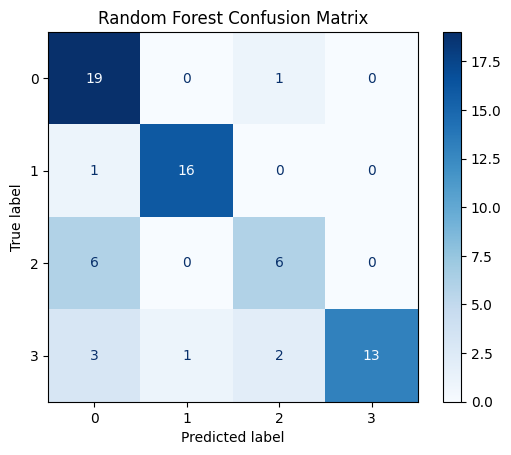

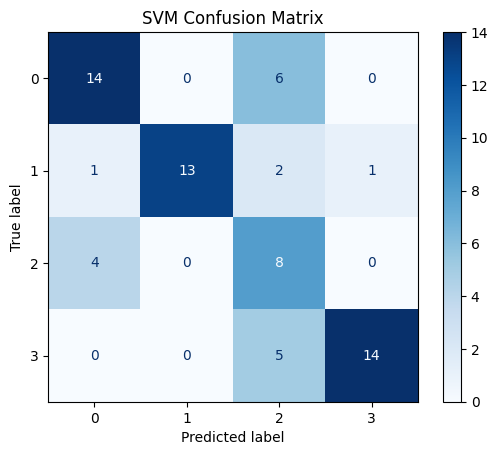

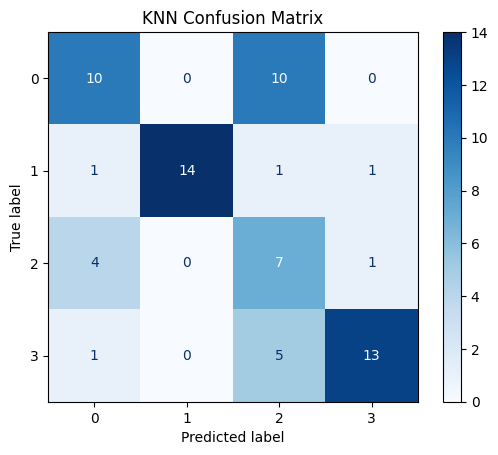

In [20]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")